In [1]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors

import copy
import datetime
import numpy as np
from math import sqrt
import math

import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat

from tqdm import tqdm
from dateutil.relativedelta import relativedelta

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import pacf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from scipy.special import inv_boxcox
from scipy.stats import boxcox

import seaborn as sns
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv('./Electric_Production.csv')
date_column = 'DATE'
data_column = 'IPG2211A2N'

df.dropna(inplace=True)
df[data_column] = df[data_column].astype(float)
df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y')
df = df.set_index([date_column])
df.sort_index(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPG2211A2N  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


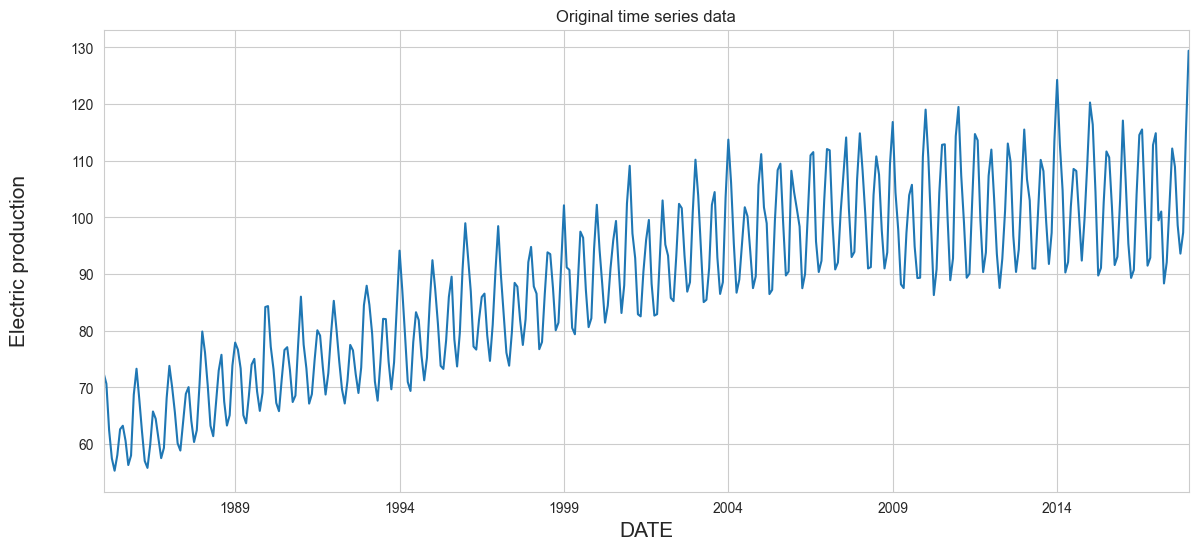

In [3]:
plt.figure(figsize=(14, 6))
plt.title('Original time series data')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Electric production', rotation=90, labelpad=30, fontsize=15)
df[data_column].plot();

In [4]:
class ARIMA:
  def __init__(self, p, d, q) -> None:
    self.p = p
    self.d = d
    self.q = q
    self.koefs = []
    self.values = []
    self.errs = []
    self.dif_steps_last_els = []


  def AR(self, values):
    values = self.I(values)
    p = self.p
    n = len(values)
    if p == 0:
      return [0. for i in range(p, n)], values

    X = []
    Y = []
    for i in range(p, n):
      x_i = values[i - p: i]
      y_i = values[i]
      X.append(x_i)
      Y.append(y_i)

    reg = LinearRegression().fit(X, Y)
    thetas = reg.coef_

    errs = []
    for i in range(p):
      errs.append(0)
    pred = []
    for i in range(p, n):
      x_i = values[i - p: i]
      y_i = values[i]
      y_ar = np.dot(x_i, thetas)
      pred.append(y_ar)
      dif = (y_i - y_ar)
      errs.append(dif)

    return errs, values

  def MA(self, values):
    res = self.AR(values)
    errs, values = res[0], res[1]

    p = self.p
    q = self.q
    if p == 0 and q == 0:
      self.koefs = []
      return values
    dels = p + max(p, q)
    n = len(values)

    X = []
    Y = []
    for i in range(dels, n):
      x_i = values[i - p: i]
      errs_i = errs[i - q: i]
      self.errs = errs_i
      self.values = x_i
      y_i = values[i]
      X.append(x_i + errs_i)
      Y.append(y_i)

    reg = LinearRegression().fit(X, Y)
    thetas_and_fi = reg.coef_
    self.koefs = thetas_and_fi
    self.intercept = reg.intercept_
    return values


  def I(self, values):
    if self.d == 0:
      return values

    if len(self.dif_steps_last_els) == self.d:
      return values

    self.dif_steps_last_els.append(values[-1])
    new_values = []
    n = len(values)
    for i in range(0, n - 1):
      new_values.append(values[i + 1] - values[i])

    return self.I(new_values)

  def anti_I(self, values):
    if self.d == 0:
      return values

    if len(self.dif_steps_last_els) == 0:
      return values

    last = self.dif_steps_last_els[-1]
    del self.dif_steps_last_els[-1]

    new_values = [last]
    n = len(values)
    for i in range(0, n):
      print(new_values[-1] + values[i])
      new_values.append(new_values[-1] + values[i])

    return self.anti_I(new_values)


  def predict(self, n):
    if len(self.koefs) == 0:
      return [0. for i in range(n)]
    pred = []
    for i in range(n):
      x_i = self.values
      errs_i = self.errs
      #y_ar = np.dot((x_i + errs_i), self.koefs) + self.intercept
      y_ar = np.dot((x_i + errs_i), self.koefs)
      pred.append(y_ar)
      v = y_ar
      if self.p != 0:
        self.values = x_i[1:]
        self.values.append(y_ar)

    pred = self.anti_I(pred)

    return pred[d:]


In [5]:
def mape( actual , pred ):
  actual, pred = np.array(actual), np.array(pred)
  return np.mean(np.abs((actual - pred) / actual)) * 100

In [6]:
# limit = 40
# best_res = []
# for p in range(limit):
#   for d in range(limit):
#     for q in range(limit):
#       values_raw = df.values
#       values = []
#       n = len(values_raw)
#       for i in range(n):
#         values.append(values_raw[i][0])
# 
#       ind = df.index
#       n = len(values)
#       train_len = int(n * 0.8)
#       train = values[:train_len]
#       test_len = n - train_len
#       test = values[train_len:]
#       arima = ARIMA(p, d, q)
#       train = arima.MA(train)
#       pred = arima.predict(test_len)
#       best_res.append([mape(test, pred), [p, d, q]])
# 
# best_res.sort()

In [7]:
# for i in range(10):
#   print(best_res[i])

In [8]:
values_raw = df.values[:-30]
values = []
n = len(values_raw)

for i in range(n):
  values.append(values_raw[i][0])

ind = df.index[:-30]
n = len(values)
train_len = int(n * 0.8)
train = values[:train_len]
test_len = n - train_len
test = values[train_len:]

p = 11
d = 1
q = 0

arima = ARIMA(p, d, q)
train = arima.MA(train)
pred = arima.predict(test_len)
# у меня было смещение по индексу, а отсюда такая большая ошибка!
pred = pred[1:] + [pred[0]]
print(pred)

90.82891034002851
103.47128258229267
110.54530064288873
107.14400447288284
95.87522311304113
89.86231430897763
94.18522143133538
107.3251416789799
114.60575234165374
106.71999927901942
95.73417708173352
87.90353068935705
91.59652796833619
103.63679659246496
110.9473051274702
107.02617277682143
95.60366476513983
89.31763290212045
94.33425181949573
106.71944284758463
113.89221812425613
107.70263190241424
95.54512322263072
87.95467401625639
92.07118973223231
103.91346548715896
111.2301379076659
106.98149982953227
95.48015943046964
88.94963477988125
94.15709770817641
106.39171854281841
113.539542808962
108.02663650048407
95.60431332871538
88.01106502857724
92.35358880619826
104.18245940410625
111.46428625643236
107.01069778920602
95.39892575395811
88.69264793346855
93.91342656382547
106.15715937804157
113.34602112207295
108.12643296884517
95.67844713519612
88.07483499780751
92.53556833561944
104.40891131927954
111.67252554095323
107.0838196150958
95.34590422995167
88.49945956129079
93.6842

In [9]:
values_raw

array([[ 72.5052],
       [ 70.672 ],
       [ 62.4502],
       [ 57.4714],
       [ 55.3151],
       [ 58.0904],
       [ 62.6202],
       [ 63.2485],
       [ 60.5846],
       [ 56.3154],
       [ 58.0005],
       [ 68.7145],
       [ 73.3057],
       [ 67.9869],
       [ 62.2221],
       [ 57.0329],
       [ 55.8137],
       [ 59.9005],
       [ 65.7655],
       [ 64.4816],
       [ 61.0005],
       [ 57.5322],
       [ 59.3417],
       [ 68.1354],
       [ 73.8152],
       [ 70.062 ],
       [ 65.61  ],
       [ 60.1586],
       [ 58.8734],
       [ 63.8918],
       [ 68.8694],
       [ 70.0669],
       [ 64.1151],
       [ 60.3789],
       [ 62.4643],
       [ 70.5777],
       [ 79.8703],
       [ 76.1622],
       [ 70.2928],
       [ 63.2384],
       [ 61.4065],
       [ 67.1097],
       [ 72.9816],
       [ 75.7655],
       [ 67.5152],
       [ 63.2832],
       [ 65.1078],
       [ 73.8631],
       [ 77.9188],
       [ 76.6822],
       [ 73.3523],
       [ 65.1081],
       [ 63.

In [10]:
len(ind[train_len:n])

74

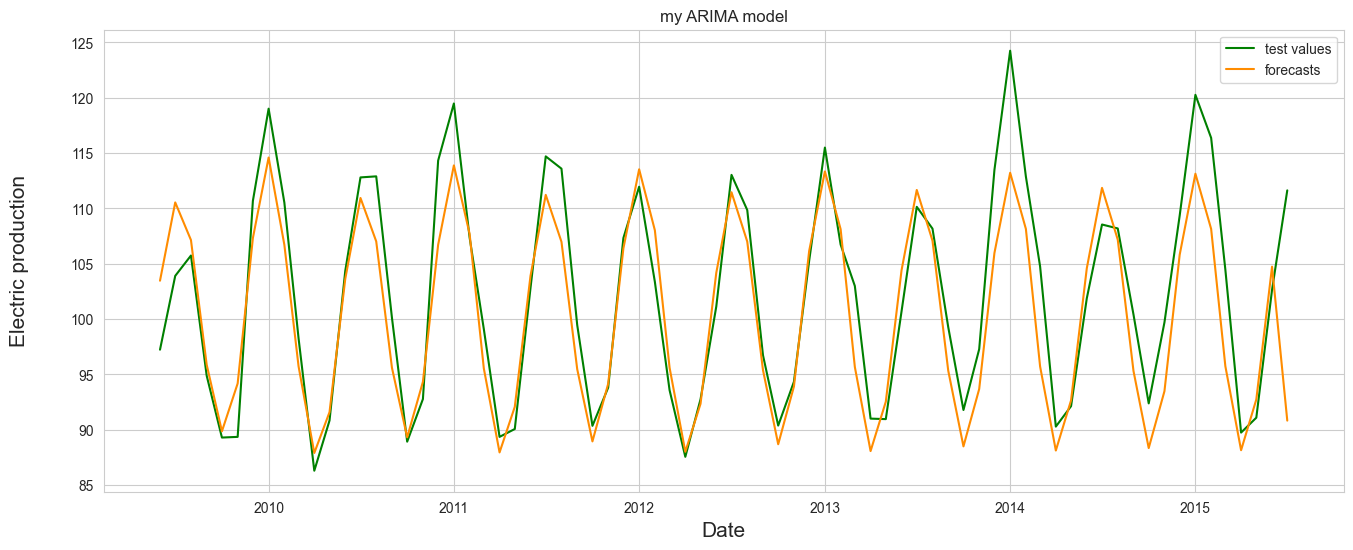

In [11]:
plt.figure(figsize=(16, 6))
plt.title('my ARIMA model')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Electric production', rotation=90, labelpad=30, fontsize=15)
plt.plot(ind[:train_len], values[:train_len], label = "train values", color = "teal")
plt.plot(ind[train_len :], values[train_len:], label = "test values", color='green')
plt.plot(ind[train_len:n], pred, label = "forecasts", color='darkorange')
plt.legend()
plt.show()

In [13]:
mse = mean_absolute_percentage_error(test, pred)
print(f'mse = {mse}')
print(f'mape = {mape(test, pred)}')

# lib ARIMA model metrics
# mse = 0.034783374936089045
# mape = 3.4783374936089047

mse = 0.03272629542917799
mape = 3.272629542917799
